### 1. Data Preprocessing

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [2]:
dir = Path('archive/train')

# Use the 'glob' method to get a list of file paths for all PNG files in the specified directory and its subdirectories
filepaths = list(dir.glob('**/*.png'))

# Extract the labels (categories) from the file paths
# The labels are obtained by splitting the file paths and extracting the parent directory name, which represents the 
# category of each image
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convert the lists of file paths and labels into pandas Series objects for further processing
filepaths = pd.Series(filepaths, name='Filepath', dtype=str)
labels = pd.Series(labels, name='Label', dtype=str)

# Create a dataframe by concatenating the 'filepaths' and 'labels' Series horizontally, representing the mapping between 
# file paths and corresponding labels
dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,archive\train\F\F1.png,F
1,archive\train\F\F10.png,F
2,archive\train\F\F100.png,F
3,archive\train\F\F101.png,F
4,archive\train\F\F102.png,F
...,...,...
99194,archive\train\V\V995.png,V
99195,archive\train\V\V996.png,V
99196,archive\train\V\V997.png,V
99197,archive\train\V\V998.png,V


In [3]:
# Count the occurrences of unique values in the 'Label' column of the 'dataframe' DataFrame
dataframe['Label'].value_counts()

N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

### 2. Data Balancing

In [4]:
samples = []

for category in ['N', 'M', 'Q', 'V', 'S', 'F']:
    # Use the 'query' method to filter the 'dataframe' DataFrame for rows where the 'Label' column matches the current category
    category_slice = dataframe.query('Label == @category')
    
    # Sample 640 random rows from the filtered category slice using 'sample' method
    # The 'random_state=1' ensures reproducibility of the random sampling
    samples.append(category_slice.sample(640, random_state=1))

# Concatenate the sampled dataframes in the 'samples' list along the row axis (vertically)
# This creates a new dataframe 'dataframe_train' that includes balanced samples for each category
dataframe_train = pd.concat(samples, axis=0)

# Shuffle the rows of the new dataframe 'dataframe_train' randomly using 'sample' method with 'frac=1.0' (all rows)
# The 'random_state=1' ensures reproducibility of the shuffling
# Reset the index of the shuffled dataframe to have consecutive integers as indices
dataframe_train = dataframe_train.sample(frac=1.0, random_state=1).reset_index(drop=True)

# Count the occurrences of each category in the 'Label' column of the 'dataframe' DataFrame
# This provides a summary of the distribution of categories in the balanced training dataset
dataframe_train['Label'].value_counts()

N    640
Q    640
S    640
F    640
M    640
V    640
Name: Label, dtype: int64

In [5]:
dataframe_train

,Filepath,Label
0,archive\train\N\N80645.png,N
1,archive\train\Q\Q644.png,Q
2,archive\train\S\S2383.png,S
3,archive\train\S\S2269.png,S
4,archive\train\F\F138.png,F
...,...,...
3835,archive\train\S\S1594.png,S
3836,archive\train\M\M5641.png,M
3837,archive\train\M\M8804.png,M
3838,archive\train\N\N46498.png,N


### 3. Image Preprocessing and Data Augmentation

In [6]:
def gray_torgb(image):
    # Convert the input image from BGR (Blue-Green-Red) color space to grayscale using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Merge the grayscale image into a 3-channel image (RGB format) by replicating the grayscale values for all channels
    image = cv2.merge((image, image, image))
    
    # Preprocess the image using the preprocessing function from ResNet50 model in Keras/TensorFlow
    # This step ensures that the image is properly preprocessed to match the requirements of the ResNet50 model
    image = tf.keras.applications.resnet50.preprocess_input(image)
    
    # Return the preprocessed RGB image
    return image

In [7]:
# Define an ImageDataGenerator for generating batches of preprocessed images for training
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=gray_torgb,   # Apply the 'gray_torgb' function to preprocess each image
    rescale=1./255,                      # Rescale the pixel values of images to the range [0, 1]
    validation_split=0.2                 # Split the data into training and validation sets (80% training, 20% validation)
)

### 4. Create Model

In [8]:
# Set parameters for image processing and data generation
size = 224              # Target size for resizing images (224x224)
color_mode = 'rgb'      # Color mode for the images (RGB format)
batch_size = 32        # Number of images in each batch

# Create image data generators for training and validation sets
train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,       # Input dataframe containing file paths and labels
    x_col='Filepath',                # Name of the dataframe column containing file paths
    y_col='Label',                   # Name of the dataframe column containing labels
    target_size=(size, size),        # Target size for resizing the images
    color_mode=color_mode,           # Color mode for the images
    class_mode='categorical',        # Type of label encoding ('categorical' for one-hot encoded labels)
    batch_size=batch_size,           # Number of images in each batch
    shuffle=True,                    # Shuffle the data during training
    seed=42,                         # Seed for random number generation (for reproducibility)
    subset='training'                # Subset of the data (training set)
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,       
    x_col='Filepath',               
    y_col='Label',                   
    target_size=(size, size),        
    color_mode=color_mode,           
    class_mode='categorical',        
    batch_size=batch_size,           
    shuffle=True,                    
    seed=42,                         
    subset='validation'              
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.


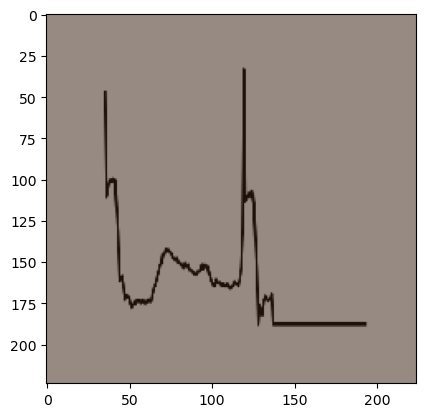

In [9]:
"""
train_images: A generator object that provides batches of preprocessed training images and their corresponding labels.
train_images[0]: Accesses the first batch of images and labels from the generator.
train_images[0][0]: Accesses the images from the first batch. The index '0' is used to access the images.
train_images[0][0][3]: Selects the 4th image from the first batch (assuming 0-based indexing), as the index '3' is used to access the image.
"""

plt.imshow(train_images[0][0][3])

In [10]:
"""
input_shape=(224, 224, 3): Specifies the shape of the input images to the ResNet50 model.

include_top=False: Specifies to exclude the top (final) layer of the ResNet50 model. False, the final fully connected layers 
                    used for classification are not included.

# weights='imagenet': Specifies to load the pre-trained weights of the ResNet50 model from the 'imagenet' dataset.

# pooling='avg': Specifies the global average pooling layer to be used as the final pooling layer in the ResNet50 model. 
                Global average pooling calculates the average of all values in each feature map, reducing them to a single value.

pretrained_model.trainable=False: freezes the weights of ResNet50 model, making them non-trainable during subsequent training.
"""

from tensorflow.keras.applications import ResNet50

pretrained_model = ResNet50(
    input_shape=(224,224,3),    
    include_top= False,         
    weights='imagenet', 
    pooling='avg'
)

pretrained_model.trainable=False

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

"""
Flatten(): This layer is added to flatten the output of the pretrained_model into a 1-dimensional vector. 
            This is necessary to connect the output of the pretrained_model to the dense layers.

Dropout(0.2): This layer applies dropout regularization with a rate of 0.2, which means 20% of the neurons 
            will be randomly set to zero during training to prevent overfitting.

Dense(128, activation='relu'): This dense layer contains 128 neurons and uses the ReLU activation function. 
                                The layer is fully connected, meaning each neuron is connected to every neuron 
                                in the previous layer.

Dense(64, activation='relu'): This dense layer contains 64 neurons and uses the ReLU activation function.

Dense(6, activation='softmax'): This dense layer contains 6 neurons and uses the softmax activation function. 
                                Softmax is used for multi-class classification to produce probabilities for each class.

model.summary(): prints summary of model's architecture, showing the number of parameters in each layer and the total 
                number of trainable parameters in the model.
"""

model = Sequential ([
    pretrained_model,
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23858630 (91.01 MB)
Trainable params: 2709

### 5. Compile and Train the Model

In [12]:
# To monitor the model's performance during training and validation
model.compile(
    loss='categorical_crossentropy', optimizer='adam', 
    metrics=[
        'Accuracy', 
        'Precision', 
        'Recall',
         tf.keras.metrics.AUC(
             num_thresholds=200,
             curve='ROC',
             summation_method='interpolation',
             multi_label=False
         )
    ]
)

In [13]:
import tensorflow as tf

result = model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images, # provides batches of preprocessed validation images and their corresponding labels
    validation_steps=768//32,   # process each batch of data during training and validation
    epochs=10
)

Epoch 1/10
96/96 [==============================] - 161s 2s/step - loss: 1.3127 - Accuracy: 0.4495 - precision: 0.7256 - recall: 0.1162 - auc: 0.8298 - val_loss: 0.8018 - val_Accuracy: 0.7240 - val_precision: 0.6505 - val_recall: 0.3854 - val_auc: 0.9462
Epoch 2/10
96/96 [==============================] - 505s 5s/step - loss: 0.7146 - Accuracy: 0.7096 - precision: 0.7759 - recall: 0.5524 - auc: 0.9524 - val_loss: 0.5321 - val_Accuracy: 0.8685 - val_precision: 0.8793 - val_recall: 0.7396 - val_auc: 0.9803
Epoch 3/10
96/96 [==============================] - 313s 3s/step - loss: 0.5141 - Accuracy: 0.8099 - precision: 0.8357 - recall: 0.7598 - auc: 0.9766 - val_loss: 0.4063 - val_Accuracy: 0.8464 - val_precision: 0.8518 - val_recall: 0.8229 - val_auc: 0.9844
Epoch 4/10
96/96 [==============================] - 358s 4s/step - loss: 0.4340 - Accuracy: 0.8418 - precision: 0.8571 - recall: 0.8242 - auc: 0.9815 - val_loss: 0.3337 - val_Accuracy: 0.8828 - val_precision: 0.8852 - val_recall: 0.873

In [14]:
model.save('ECG_Model.h5')

c:\Users\Xuanting\anaconda3\envs\pyspark\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
